In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('poster')

In [5]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
df = pd.read_pickle('CCPA.pkl.gz')

In [9]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [10]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

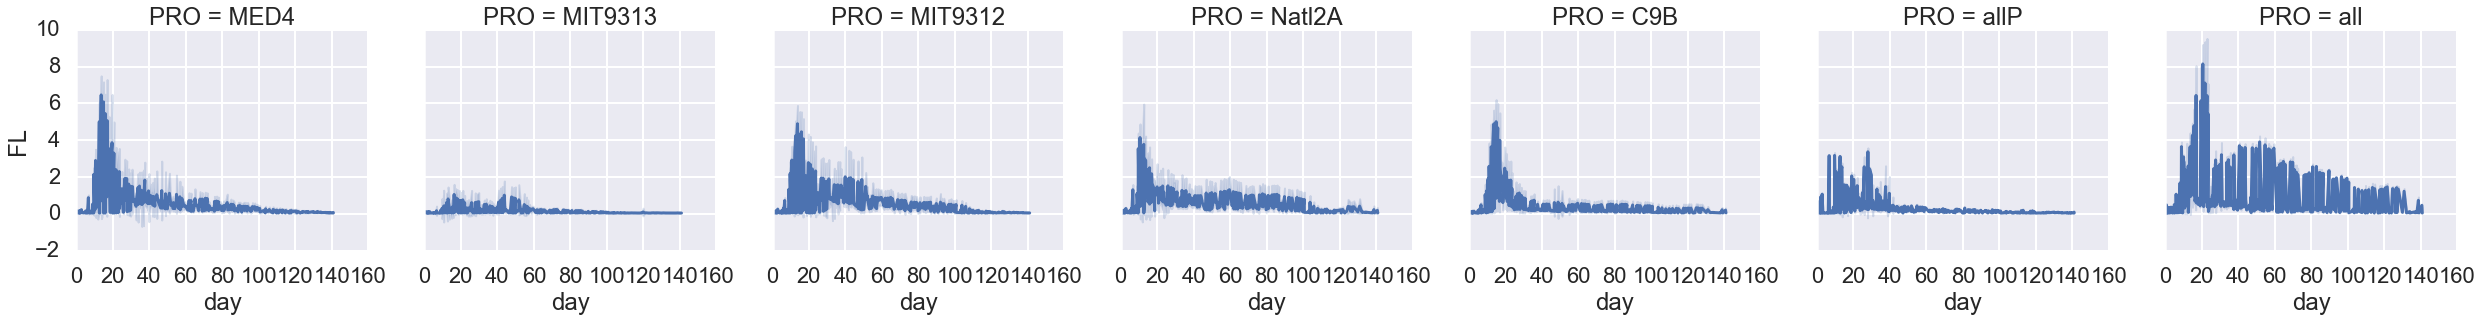

In [10]:
sns.relplot(data=df, x='day', y='FL', kind='line',  col='PRO', ci='sd')

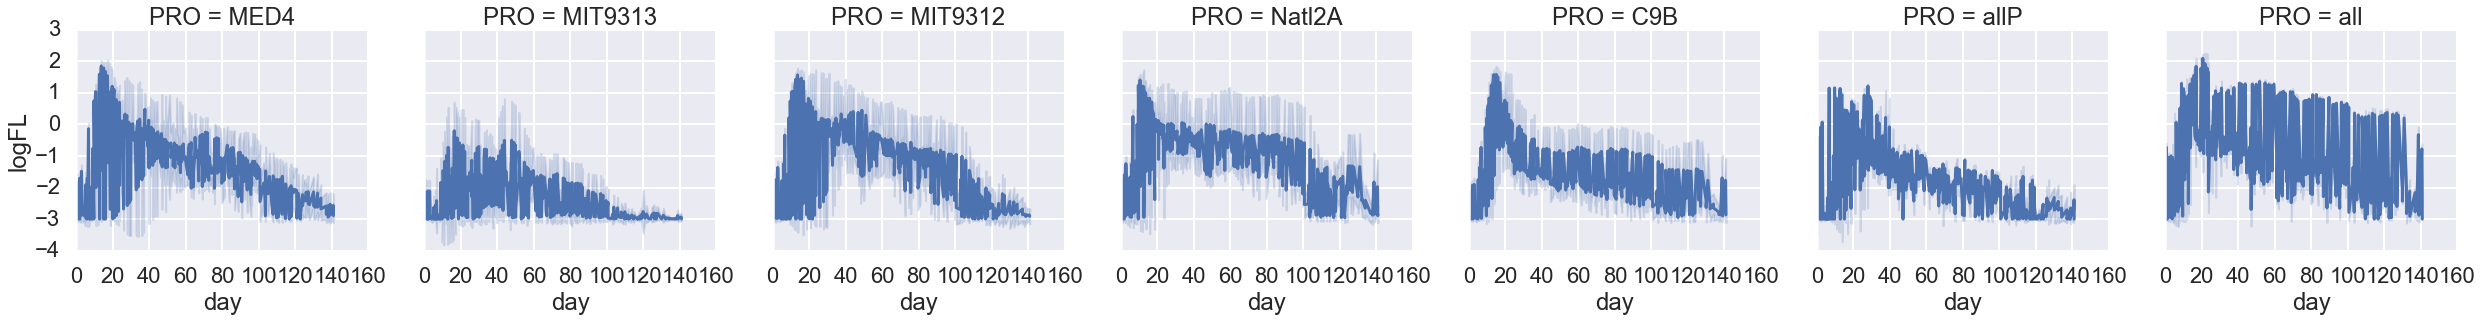

In [11]:
sns.relplot(data=df, x='day', y='logFL', kind='line',  col='PRO', ci='sd')

In [30]:
d = cp.generate_decay(dfc, scale=False)

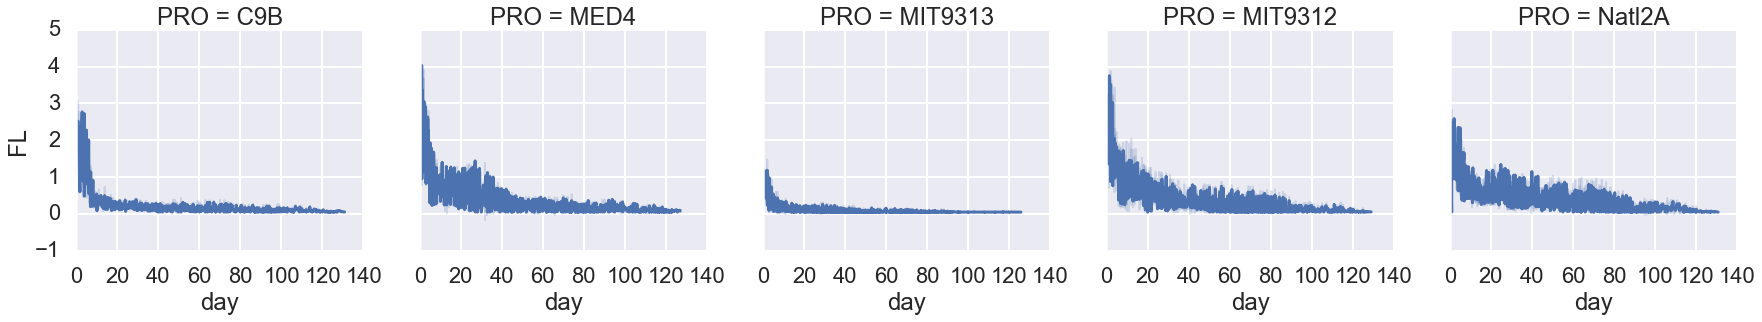

In [31]:
sns.relplot(data=d, x='day', y='FL', kind='line',  col='PRO', ci='sd')

In [32]:
def apply_fit(df, model, print_popt=True):
    x = df['day']
    y = df['FL']
    p0= [0.5, 0.5,0.5,0.5]
    y_pred = 0
    y_pred_p0 = 0
    score = 0
    popt = []
    score_p0 = 0
    popt_p0 = []
    
    try:
        popt, pcov = curve_fit(model, x, y, method='dogbox', loss='soft_l1', f_scale=0.1, #p0=p0
                              # bounds = (0, np.inf)
                              )
        y_pred = model (x, *popt)
        score = r2_score(y, y_pred)
        
    except Exception as e:
        print(e)

    try:
        popt_p0, pcov_p0 = curve_fit(model, x, y, method='dogbox', loss='soft_l1', f_scale=0.1, p0=p0
                              # bounds = (0, np.inf)
                              )
        y_pred_p0 = model (x, *popt)
        score_p0 = r2_score(y, y_pred)
        
    except Exception as e:
        print(e)

    if score_p0 > score:
        score = score_p0
        y_pred = y_pred_p0
        popt = popt_p0
    
        
    if print_popt:
        print(popt)

    df['y_pred'] = y_pred
    for i in range(len(popt)):
        df[f'popt_{i}'] = popt[i]

        
    return df


In [33]:
def apply_fit_2(df, model):
    x = df['day']
    y = df['FL']
    popt, pcov = curve_fit(model, x, y, #method='dogbox', loss='soft_l1', f_scale=0.1, 
                          # bounds = (0, np.inf)
                          )
    y_pred = model (x, *popt)
    print(popt)
    df['y_pred'] = y_pred
    return df


In [34]:
# fit all functions
functions = {'cubic' : cp.model_cubic, 
             'exponential' :cp.model_exponential,
             'hyperbolic' : cp.model_hyperbolic,
             #'exponential_segmented' : cp.model_exponential_segmented,
             'gompertz' : cp.model_gompertz,
             'harmonic' : cp.model_harmonic,
             'linear' : cp.model_linear,
             'logistic3' : cp.model_logistic3,
             'logistic4' : cp.model_logistic4,
             'loglogistic' : cp.model_loglogistic,
             'rodbard4' : cp.model_rodbard4,
             'scurve' : cp.model_scurve,
            }
dfe = d.loc[:, ['day', 'experiment_sample', 'experiment', 'PRO', 'ALT', 'sample', 'culture', 'FL']]
for n in method_cols:
    f = functions[n]
    print(n)
    t = dfe.groupby('experiment_sample').apply(lambda x: apply_fit(x, f))
    dfe[n] = t['y_pred']


exponential
[3.13796447 0.28850185 0.23243319 1.        ]
[3.13796447 0.28850185 0.23243319 1.        ]
[3.15524358 0.28854413 0.21355025 1.        ]
[3.02820901 0.31943397 0.21943086 1.        ]
[1.56523794 0.02973404 0.0101065  1.        ]
[2.16359439 0.05547608 0.08243461 1.        ]
[ 1.46498477  0.02856285 -0.00302461  1.        ]
[0.70896018 0.24196126 0.05355432 1.        ]
[0.64337105 0.2602097  0.05695251 1.        ]
[0.77837506 0.12013545 0.06836048 1.        ]
[1.59570521 0.04115569 0.08778657 1.        ]
[1.78026852 0.035824   0.06715133 1.        ]
[1.61370546 0.03717757 0.07959601 1.        ]
[1.46383433 0.13807328 0.32322181 1.        ]
[2.08360194 0.15555808 0.29164986 1.        ]
[1.84196683 0.09971272 0.32720671 1.        ]
[2.48632858 0.18081383 0.09015241 1.        ]
[2.37230466 0.18465669 0.07764617 1.        ]
[2.27181082 0.14768547 0.07678043 1.        ]
[1.57268591 0.03345777 0.08625722 1.        ]
[1.39619549 0.04593117 0.1414184  1.        ]
[0.57754698 0.1333

[2.30218463 0.15069422 0.0645165  1.        ]
[2.90375379 0.19189139 0.16086994 1.        ]
[ 2.19850312  0.02079342 -0.83620543  1.        ]
[ 2.12321681  0.03411967 -0.06504609  1.        ]
[1.89566108 0.31767486 0.08067559 1.        ]
[1.70786107 0.28097432 0.07424474 1.        ]
[1.47667666 0.25443633 0.06421546 1.        ]
[3.78188957 0.46675088 0.32009516 1.        ]
[4.2778618  0.42212593 0.18950984 1.        ]
[ 1.87961302  0.03462718 -0.00450416  1.        ]
[ 1.61417427  0.01917065 -0.23462575  1.        ]
[2.21942401 0.12136681 0.35649726 1.        ]
[3.7480853  0.25904699 0.19622955 1.        ]
[0.81296844 0.17019309 0.05018972 1.        ]
[0.70904531 0.1899852  0.04957051 1.        ]
[3.67142963 0.08498281 0.08048936 1.        ]
[2.91457833 0.20018066 0.14928605 1.        ]
[3.63834137 0.08705849 0.07406401 1.        ]
[ 1.45348372  0.03144341 -0.00918713  1.        ]
[2.00150067 0.03612253 0.0229643  1.        ]
[3.32378965 0.15104046 0.23640565 1.        ]
[1.85644521 0.

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


In [35]:
dfe['Diff'] = dfe.FL - dfe.exponential

In [36]:
dfe.head()

day experiment_sample experiment  PRO ALT sample     culture     FL  \
0  0.00           e3, 10A         e3  C9B  DE    10A  Co_Culture  3.352   
1  1.03           e3, 10A         e3  C9B  DE    10A  Co_Culture  2.439   
2  2.14           e3, 10A         e3  C9B  DE    10A  Co_Culture  2.576   
3  3.10           e3, 10A         e3  C9B  DE    10A  Co_Culture  2.114   
4  4.09           e3, 10A         e3  C9B  DE    10A  Co_Culture  1.238   

   exponential      Diff  
0     3.370398 -0.018398  
1     2.563713 -0.124713  
2     1.924889  0.651111  
3     1.515456  0.598544  
4     1.196689  0.041311

J.J. Arps (1945):

Exponential:  The decline rate a does not varies with q. 

              q = q0* e^(-a*t)

Harmonic:     The decline rate a varies linearly with q. 

              q = q0 / (1 + a * t)

Hyperbolic:   The decline rate a varies geometrically with q 

              q = q0 / (1 + d*a*t)^(1/d)
     
     
 3-­‐parameter  Logistic :
        Y(t)  =  b1   /  [1  +  b2 *exp(  b3 *t  )] 
        
4-­‐parameter  Logistic 

        Y(t)  =  b1  +  (b2   –  b1 )  /  [1  +  exp(b3 *(t  –  b4 ))] 

3-­‐parameter  Rodbard 

Y(t)  =  (1   –  b4 )/[1  +  (t/b3 ) b2 ]  +  b4 

4-­‐parameter  Rodbard 

    Y(t)  =  (b1   –  b4 )/[1  +  (t/b3 ) b2 ]  +  b4 

Gompertz 

    Y(t)  =  b1 *exp(  –  b2* exp(  –  b3 *t)) 

Log-­‐Logistic 

    Y(t)  =  b1  –  log(1  +  b2 *exp( –  b3 *t) 

First-­‐order  Decay 

    Y(t)  =  b1 *exp(  –  b2 *t)  +  b3


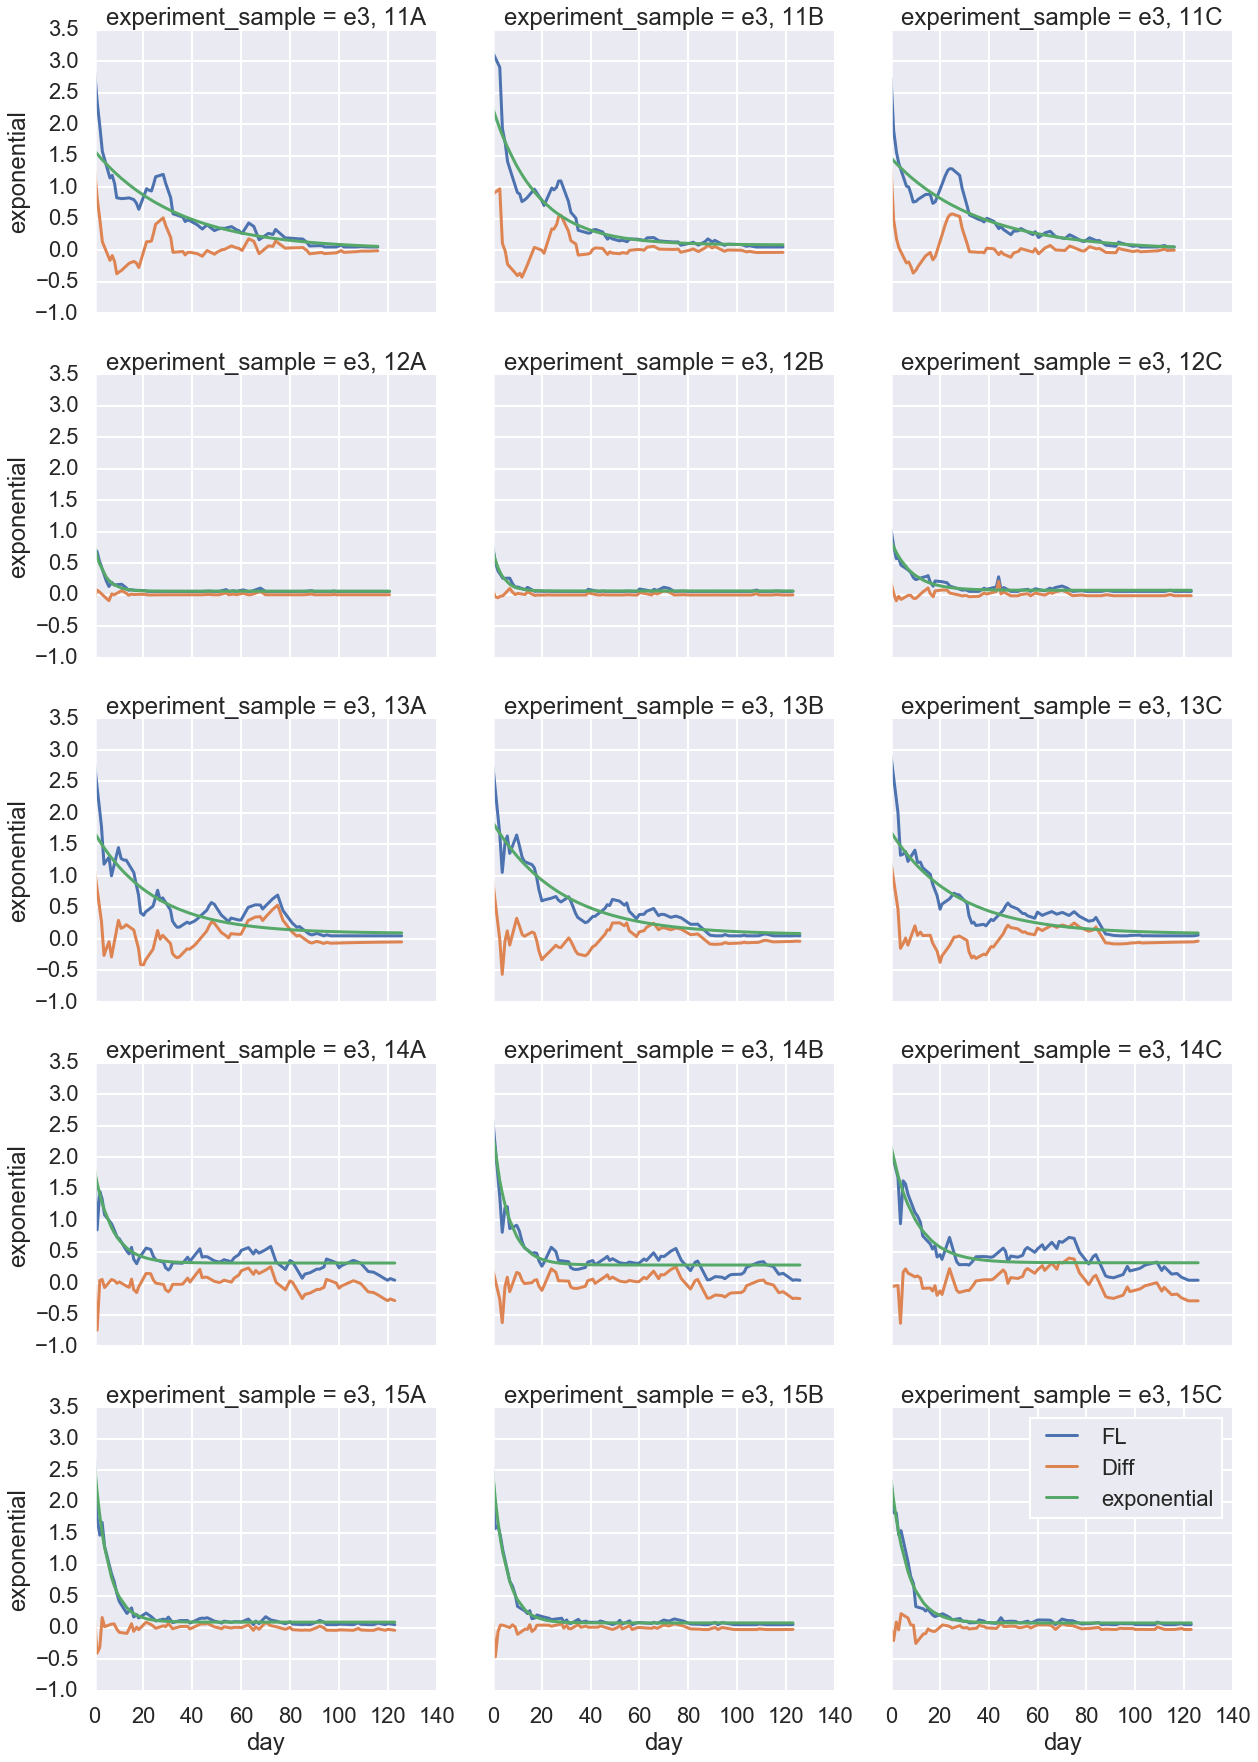

In [38]:
#for e in ['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', ]:
#for e in ['e1' ]:

g = sns.FacetGrid(dfe.loc[(dfe.experiment.isin(['e3'])) & (dfe.culture == 'Co_Culture') & (dfe.ALT == 'DE1')], 
                          col = "experiment_sample", col_wrap=3, height=5, aspect=1.2 , legend_out=True)
cols =     ['FL', 'Diff']
cols.extend(method_cols)
colors = sns.color_palette(n_colors=len(cols), )

for i,p in zip(cols, colors):
    g.map(sns.lineplot, "day", i,  label=i, color=p)
        
plt.legend(loc='best')

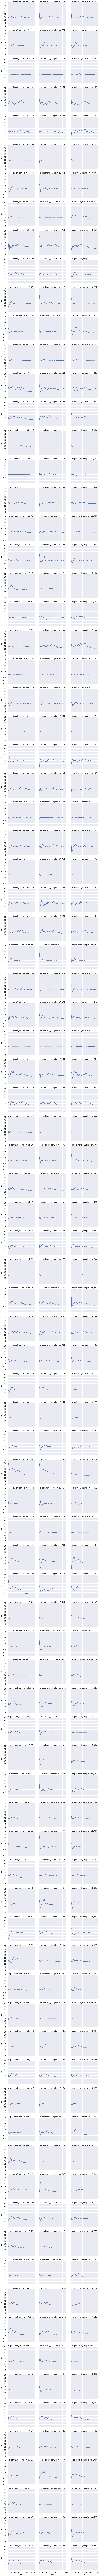

In [39]:
g = sns.FacetGrid(dfe, 
                          col = "experiment_sample", col_wrap=3, height=5, aspect=1.2 , legend_out=True)
cols =     ['FL', 'exponential', 'Diff']
cols =     ['Diff']
colors = sns.color_palette(n_colors=len(cols), )

for i,p in zip(cols, colors):
    g.map(sns.lineplot, "day", i,  label=i, color=p)
        
plt.legend(loc='best')

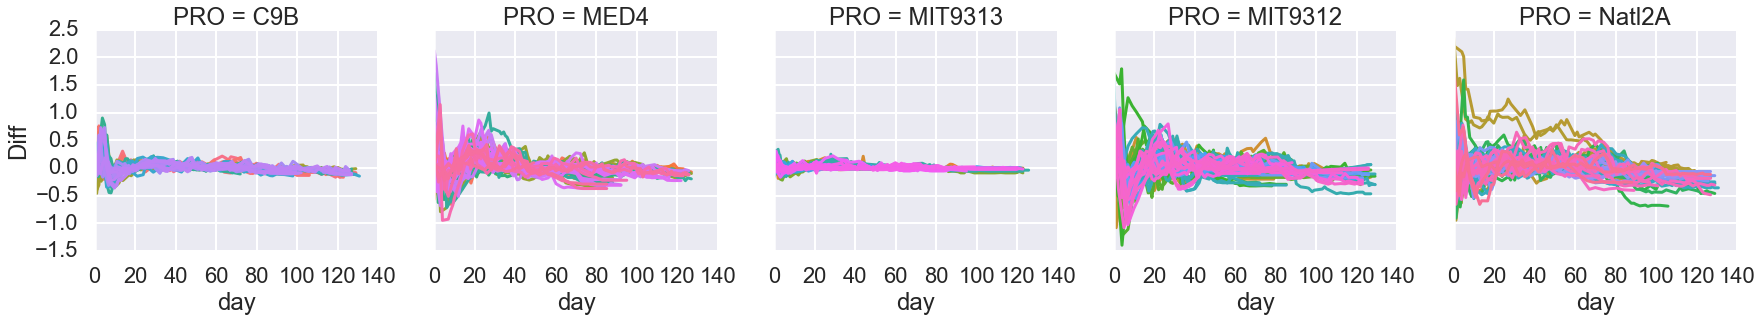

In [54]:
sns.relplot(data=dfe, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', 
            x='day', y='Diff', kind='line', hue='sample', legend=False)

In [47]:
X = cp.experiments2X(dfe, value_col='Diff')
metadf = cp.get_meta(dfe)
dfpca = cp.run_pca(X=X, metadf=metadf)


Variance percent explained
 [0.8456252  0.06482977]


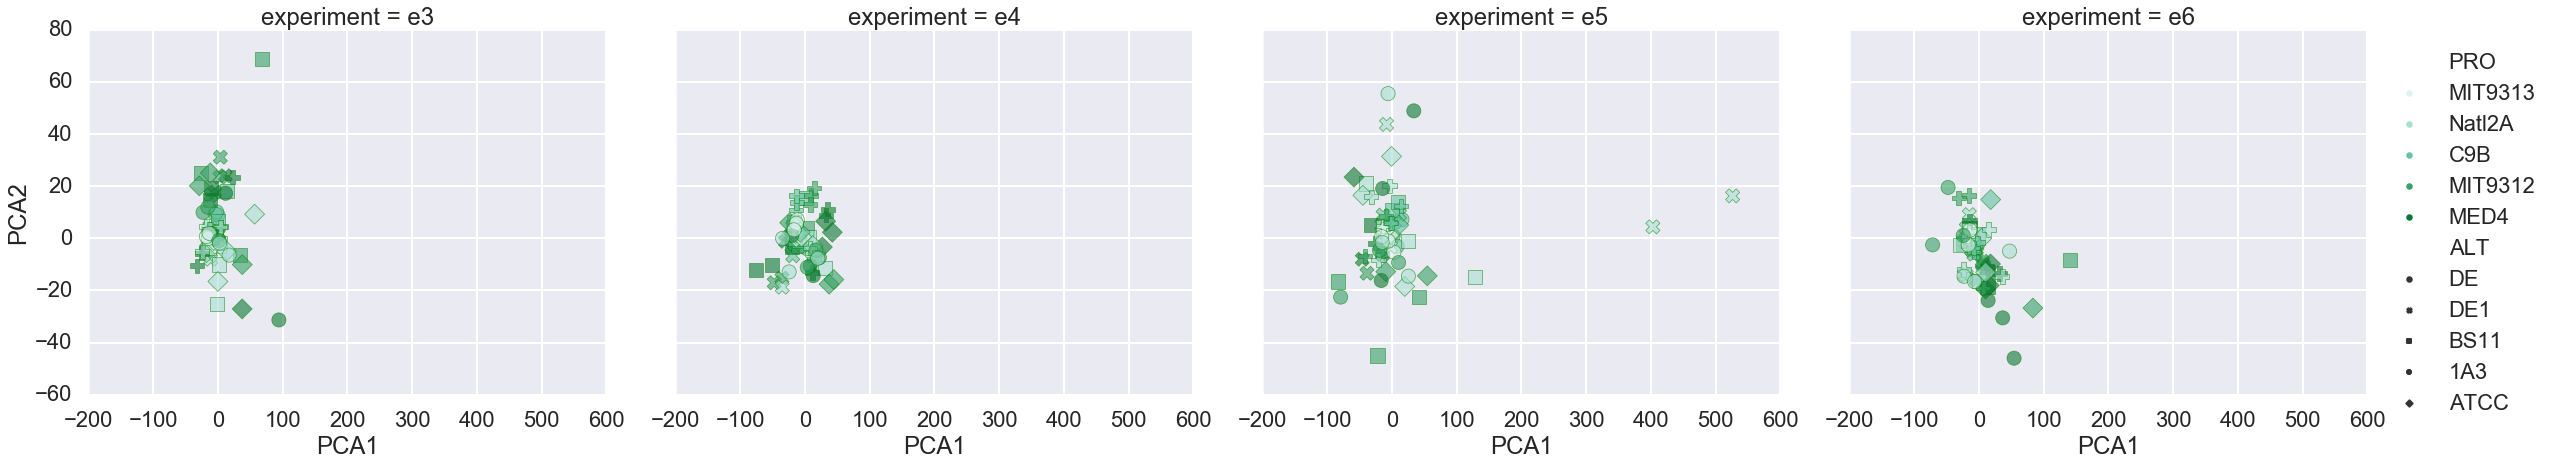

In [52]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            style='ALT', col='experiment',
            s=200, alpha=0.6, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder,edgecolor=pedge,
           )

In [20]:
def compute_score (df, y_col= 'FL', 
                   ref_cols = method_cols,
                   meta_cols = ('PRO', 'ALT', 'sample', 'culture', 'experiment')
                  ):
    res =  {i :  r2_score(df[y_col], df[i]) for i in ref_cols}
    
    #res.update({f'{i}_log_error' :  mean_squared_log_error(df[y_col], df[i]) for i in ref_cols})
    res.update({i : df[i].unique()[0] for i in meta_cols})
    
    return pd.Series(res)
                   

scores = dfe.groupby('experiment_sample').apply(compute_score)

for i in method_cols:
    scores.loc[scores[i] < 0,i ] = np.nan
scores


cubic  exponential  gompertz  harmonic    linear  \
experiment_sample                                                        
e1, 10A            0.423485     0.930438  0.928540  0.935724  0.149075   
e1, 10B            0.390028     0.920546  0.924637  0.937349  0.191272   
e1, 10C            0.333133     0.945157  0.946540  0.947207  0.151826   
e1, 11A            0.710588     0.955676  0.202028  0.972754  0.236990   
e1, 11B            0.652453     0.939501  0.964118  0.978546  0.232238   
e1, 11C            0.687152     0.902080       NaN  0.963674  0.319419   
e1, 12A            0.593085     0.928814  0.936954  0.933649  0.306816   
e1, 12B            0.508744     0.900916  0.899752  0.883335  0.240346   
e1, 12C            0.527534     0.861010  0.352248  0.837533  0.296398   
e1, 13A            0.930016     0.928247  0.945854  0.955258  0.686537   
e1, 13B            0.900831     0.903806  0.912251  0.918416  0.680154   
e1, 13C            0.947406     0.955704       NaN  0.963610  0.584786   
e1, 14A                 NaN     0.781114  0.794612  0.825992  0.362130   
e1, 14B            0.472984     0.566504  0.578887  0.647011  0.489168   
e1, 14C            0.397114     0.559888  0.570230  0.601941  0.336943   
e1, 15A            0.713708     0.977008  0.984420  0.977084  0.198517   
e1, 15B            0.748858     0.985108  0.985417  0.969572  0.180813   
e1, 15C                 NaN     0.982462  0.204971  0.948729  0.156878   
e1, 16A            0.859107     0.914955  0.925094  0.939455  0.455531   
e1, 16B            0.809438     0.927340  0.094081  0.938629  0.342601   
e1, 16C            0.775791     0.840282  0.892207  0.930570  0.354963   
e1, 17A            0.811791     0.941993  0.952667  0.947137  0.395454   
e1, 17B            0.813886     0.918289  0.320968  0.930061  0.439022   
e1, 17C            0.553010     0.962431  0.966890  0.960461  0.234595   
e1, 18A            0.602392     0.766953  0.809064  0.864038  0.453751   
e1, 18B            0.932307     0.931373  0.933343  0.935999  0.677635   
e1, 18C                 NaN     0.920975  0.930632  0.936401  0.602144   
e1, 19A            0.584409     0.391564  0.401563  0.504081  0.590389   
e1, 19B                 NaN     0.462184       NaN  0.587498  0.613023   
e1, 19C            0.704687     0.663559       NaN  0.759486  0.594919   
...                     ...          ...       ...       ...       ...   
e7, 24C            0.644075     0.633862  0.596644  0.634245  0.633653   
e7, 25C            0.893958     0.941302  0.957076  0.968125  0.585296   
e7, 2A             0.968681     0.955614       NaN  0.932084  0.663845   
e7, 2C             0.917485     0.930287  0.924535  0.910059  0.549685   
e7, 36A            0.891601     0.900069  0.906132  0.914606  0.667865   
e7, 36B            0.651400     0.858220  0.884128  0.906999  0.392056   
e7, 37A            0.151123     0.852564  0.839456  0.842394  0.211647   
e7, 37B            0.115278     0.925214  0.906592  0.880306  0.097358   
e7, 37C            0.252022     0.923840  0.910235  0.889914  0.133408   
e7, 3A                  NaN     0.884433       NaN  0.875345  0.721027   
e7, 3B             0.878637     0.889729  0.895445  0.911866  0.649362   
e7, 3C             0.756901     0.772719  0.800058  0.834648  0.528157   
e7, 4A             0.819414     0.822712       NaN  0.833831  0.730996   
e7, 4B             0.829620     0.840512  0.859886  0.874382  0.675716   
e7, 4C             0.846094     0.869402  0.888615  0.903267  0.616351   
e7, 5A             0.756763     0.752949  0.755224  0.014198  0.690241   
e7, 5B             0.673432     0.858443  0.884033  0.924188  0.388164   
e7, 5C             0.616997     0.919679  0.931818  0.951295  0.319489   
e7, 6A             0.537820     0.883114  0.897035  0.918183  0.322840   
e7, 6B             0.759574     0.891235  0.385694  0.932462  0.442630   
e7, 6C             0.693023     0.773658  0.366222  0.895023  0.448276   
e7, 7A             0.92750

In [21]:
scoresm = scores.melt(id_vars=['PRO','ALT', 'sample', 'culture', 'experiment'],
           value_vars=method_cols, 
                      var_name='method', value_name='r2score'
                     )

In [22]:
scoresm

PRO      ALT sample      culture experiment      method   r2score
0         C9B       DE    10A   Co_Culture         e1       cubic  0.423485
1         C9B       DE    10B   Co_Culture         e1       cubic  0.390028
2         C9B       DE    10C   Co_Culture         e1       cubic  0.333133
3        MED4      DE1    11A   Co_Culture         e1       cubic  0.710588
4        MED4      DE1    11B   Co_Culture         e1       cubic  0.652453
5        MED4      DE1    11C   Co_Culture         e1       cubic  0.687152
6     MIT9313      DE1    12A   Co_Culture         e1       cubic  0.593085
7     MIT9313      DE1    12B   Co_Culture         e1       cubic  0.508744
8     MIT9313      DE1    12C   Co_Culture         e1       cubic  0.527534
9     MIT9312      DE1    13A   Co_Culture         e1       cubic  0.930016
10    MIT9312      DE1    13B   Co_Culture         e1       cubic  0.900831
11    MIT9312      DE1    13C   Co_Culture         e1       cubic  0.947406
12     Natl2A      DE1    14A   Co_Culture         e1       cubic       NaN
13     Natl2A      DE1    14B   Co_Culture         e1       cubic  0.472984
14     Natl2A      DE1    14C   Co_Culture         e1       cubic  0.397114
15        C9B      DE1    15A   Co_Culture         e1       cubic  0.713708
16        C9B      DE1    15B   Co_Culture         e1       cubic  0.748858
17        C9B      DE1    15C   Co_Culture         e1       cubic       NaN
18       MED4     BS11    16A   Co_Culture         e1       cubic  0.859107
19       MED4     BS11    16B   Co_Culture         e1       cubic  0.809438
20       MED4     BS11    16C   Co_Culture         e1       cubic  0.775791
21    MIT9313     BS11    17A   Co_Culture         e1       cubic  0.811791
22    MIT9313     BS11    17B   Co_Culture         e1       cubic  0.813886
23    MIT9313     BS11    17C   Co_Culture         e1       cubic  0.553010
24    MIT9312     BS11    18A   Co_Culture         e1       cubic  0.602392
25    MIT9312     BS11    18B   Co_Culture         e1       cubic  0.932307
26    MIT9312     BS11    18C   Co_Culture         e1       cubic       NaN
27     Natl2A     BS11    19A   Co_Culture         e1       cubic  0.584409
28     Natl2A     BS11    19B   Co_Culture         e1       cubic       NaN
29     Natl2A     BS11    19C   Co_Culture         e1       cubic  0.704687
...       ...      ...    ...          ...        ...         ...       ...
5855   Natl2A     ATCC    24C   Co_Culture         e7  hyperbolic       NaN
5856      C9B     ATCC    25C   Co_Culture         e7  hyperbolic  0.969021
5857  MIT9313      1A3     2A   Co_Culture         e7  hyperbolic  0.933494
5858  MIT9313      1A3     2C   Co_Culture         e7  hyperbolic  0.930175
5859     allP  all_Pro    36A      All_Pro         e7  hyperbolic  0.923520
5860     allP  all_Pro    36B      All_Pro         e7  hyperbolic  0.904791
5861      all      all    37A  All_strains         e7  hyperbolic       NaN
5862      all      all    37B  All_strains         e7  hyperbolic  0.924828
5863      all      all    37C  All_strains         e7  hyperbolic  0.901991
5864  MIT9312      1A3     3A   Co_Culture         e7  hyperbolic  0.868174
5865  MIT9312      1A3     3B   Co_Culture         e7  hyperbolic  0.920636
5866  MIT9312      1A3     3C   Co_Culture         e7  hyperbolic  0.857957
5867   Natl2A      1A3     4A   Co_Culture         e7  hyperbolic       NaN
5868   Natl2A      1A3     4B   Co_Culture         e7  hyperbolic       NaN
5869   Natl2A      1A3     4C   Co_Culture         e7  hyperbolic       NaN
5870      C9B      1A3     5A   Co_Culture         e7  hyperbolic       NaN
5871      C9B      1A3     5B   Co_Culture         e7  hyperbolic  0.939516
5872      C9B      1A3     5C   Co_Culture         e7  hyperbolic  0.951928
5873     MED4       DE     6A   Co_Culture         e7  hyperbolic  0.920766
5874     MED4       DE     6B   Co_Culture         e7  hyperbolic  0.931677
5875     MED4       DE     6C   Co_Culture         e7  hyp

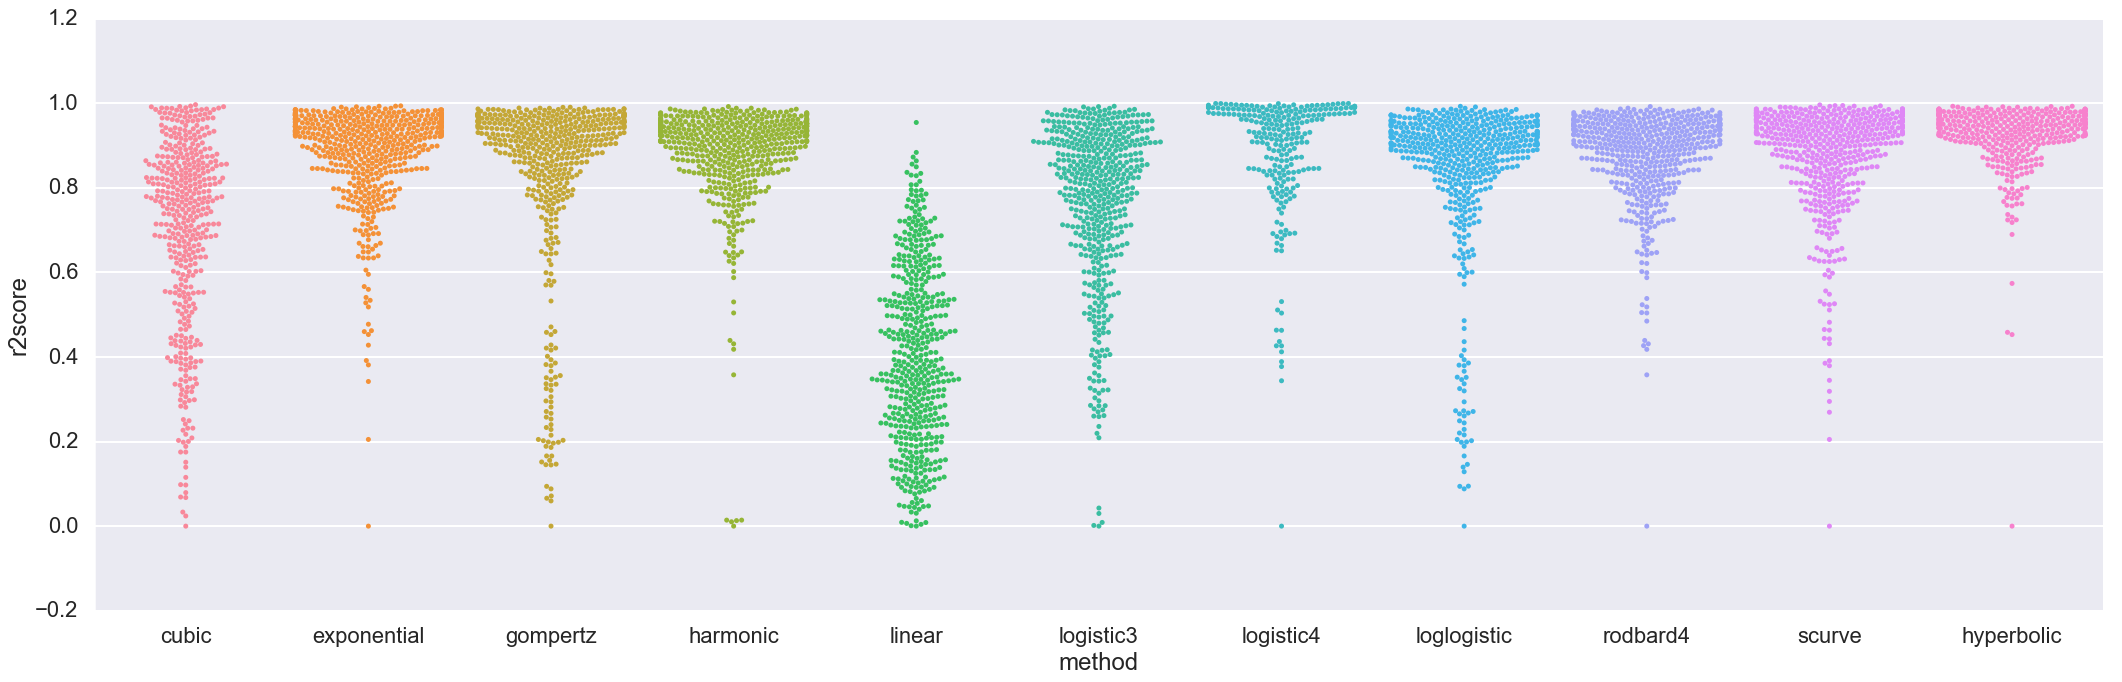

In [23]:
sns.catplot(data=scoresm, x='method', y='r2score', kind='swarm',
            #hue='PRO',
            aspect=3, height=10)

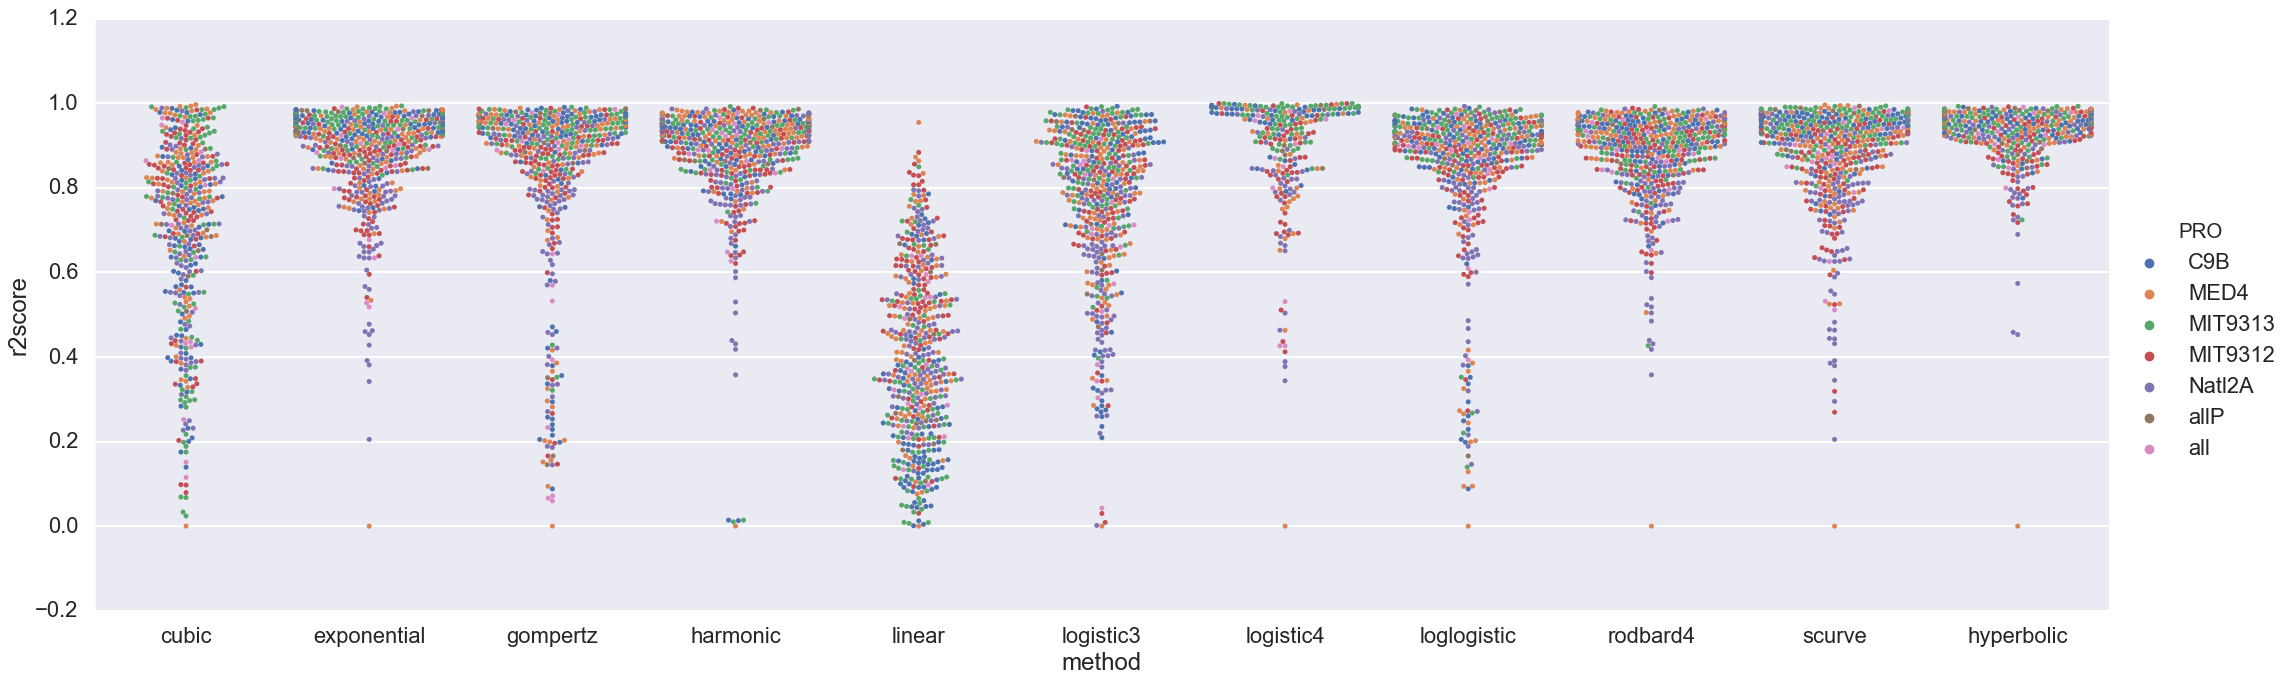

In [24]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            hue='PRO', kind='swarm',
            aspect=3, height=10)

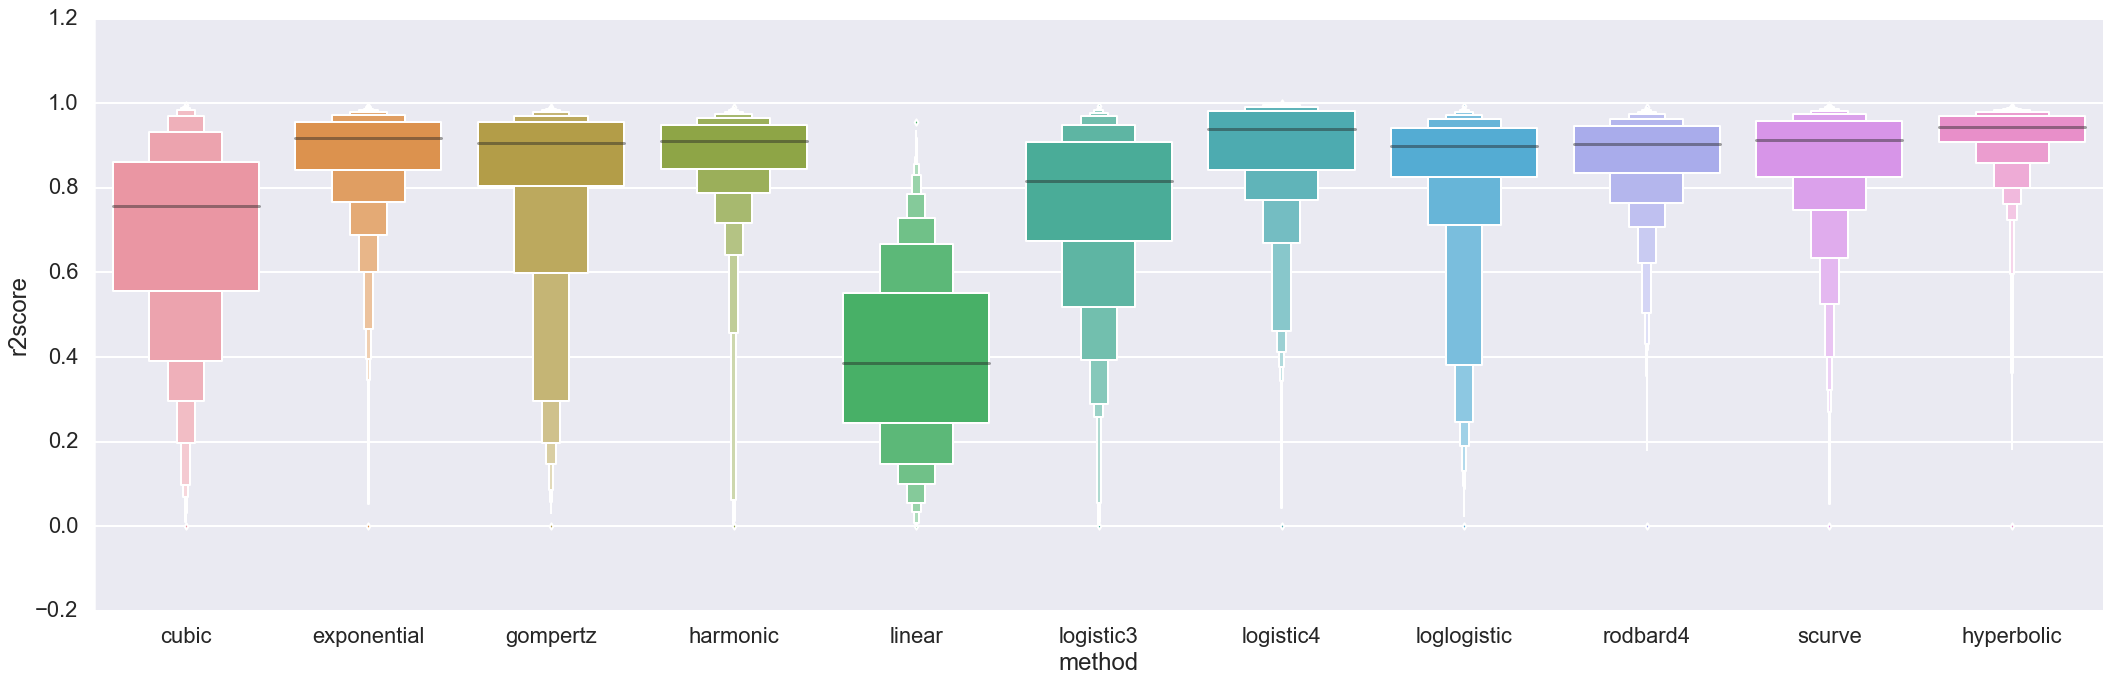

In [25]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            #hue='PRO',
            kind='boxen',
            aspect=3, height=10)

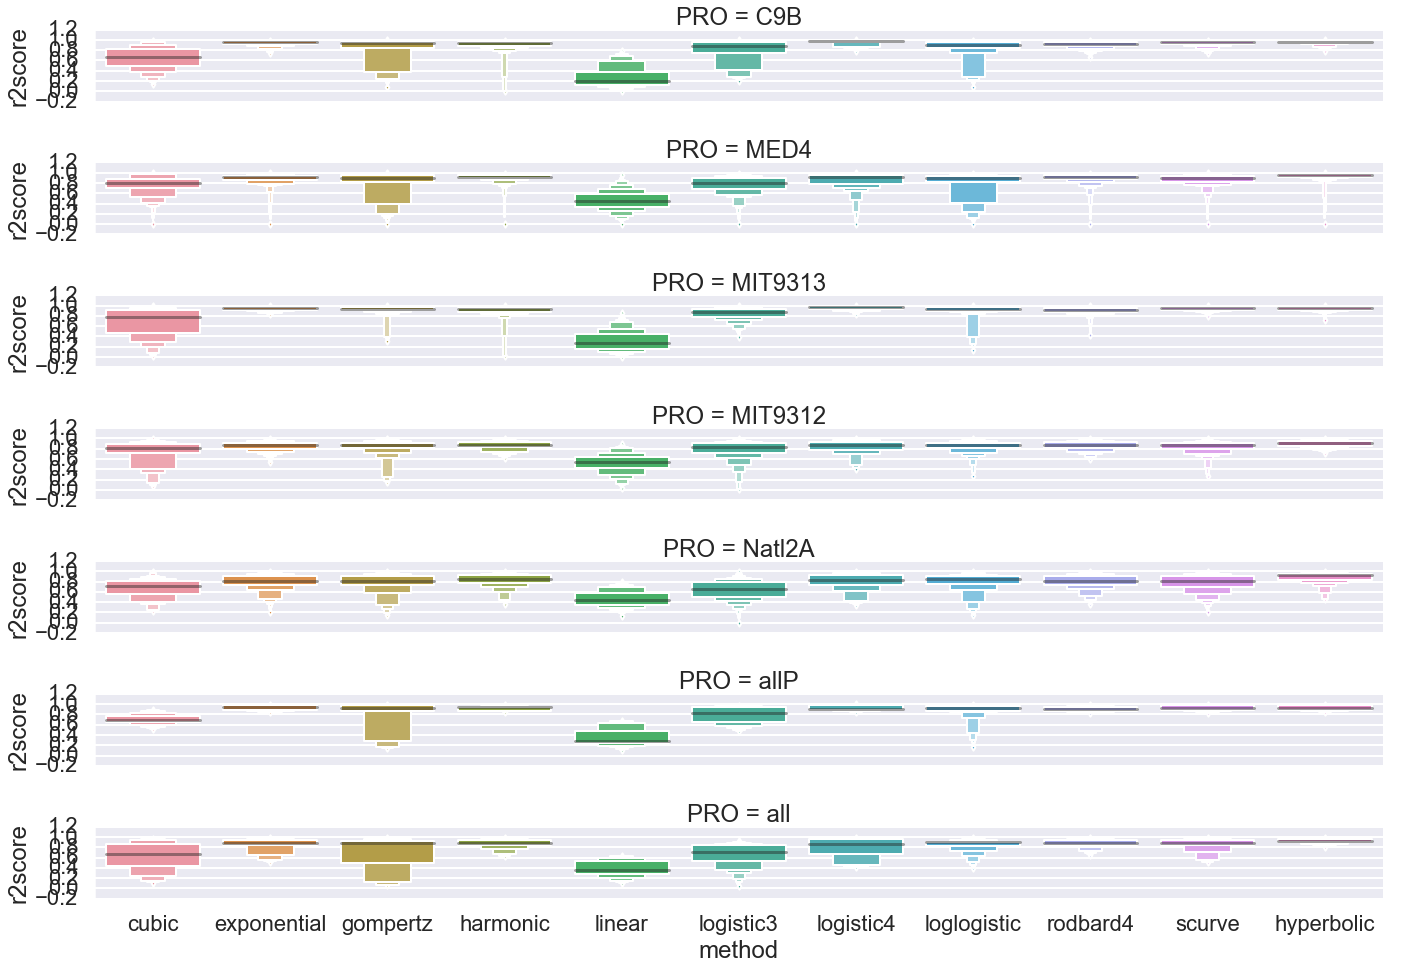

In [51]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            #hue='PRO',
            kind='boxen', 
            row='PRO',
            aspect=10, height=2)

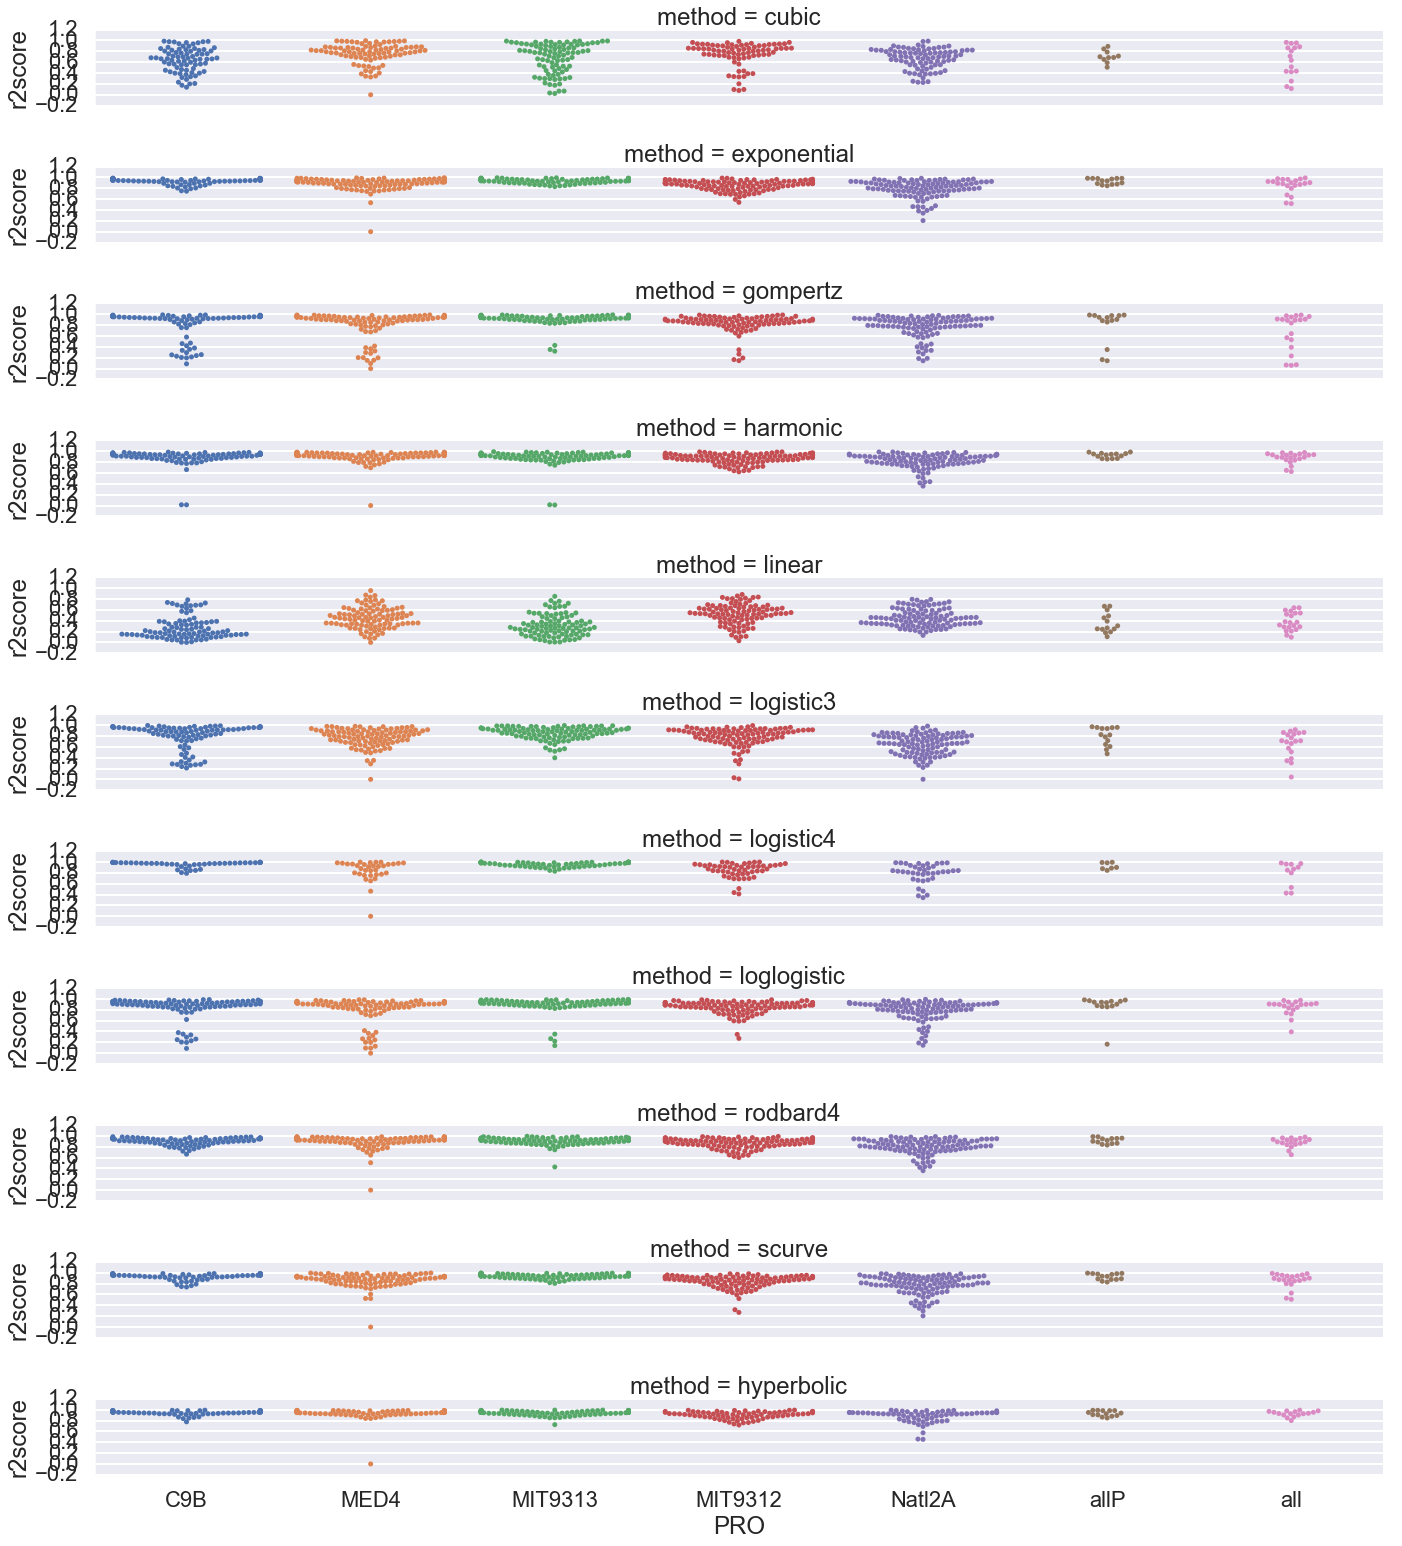

In [52]:
sns.catplot(data=scoresm, x='PRO', y='r2score', 
            #hue='PRO',
            kind='swarm', 
            row='method',
            aspect=10, height=2)

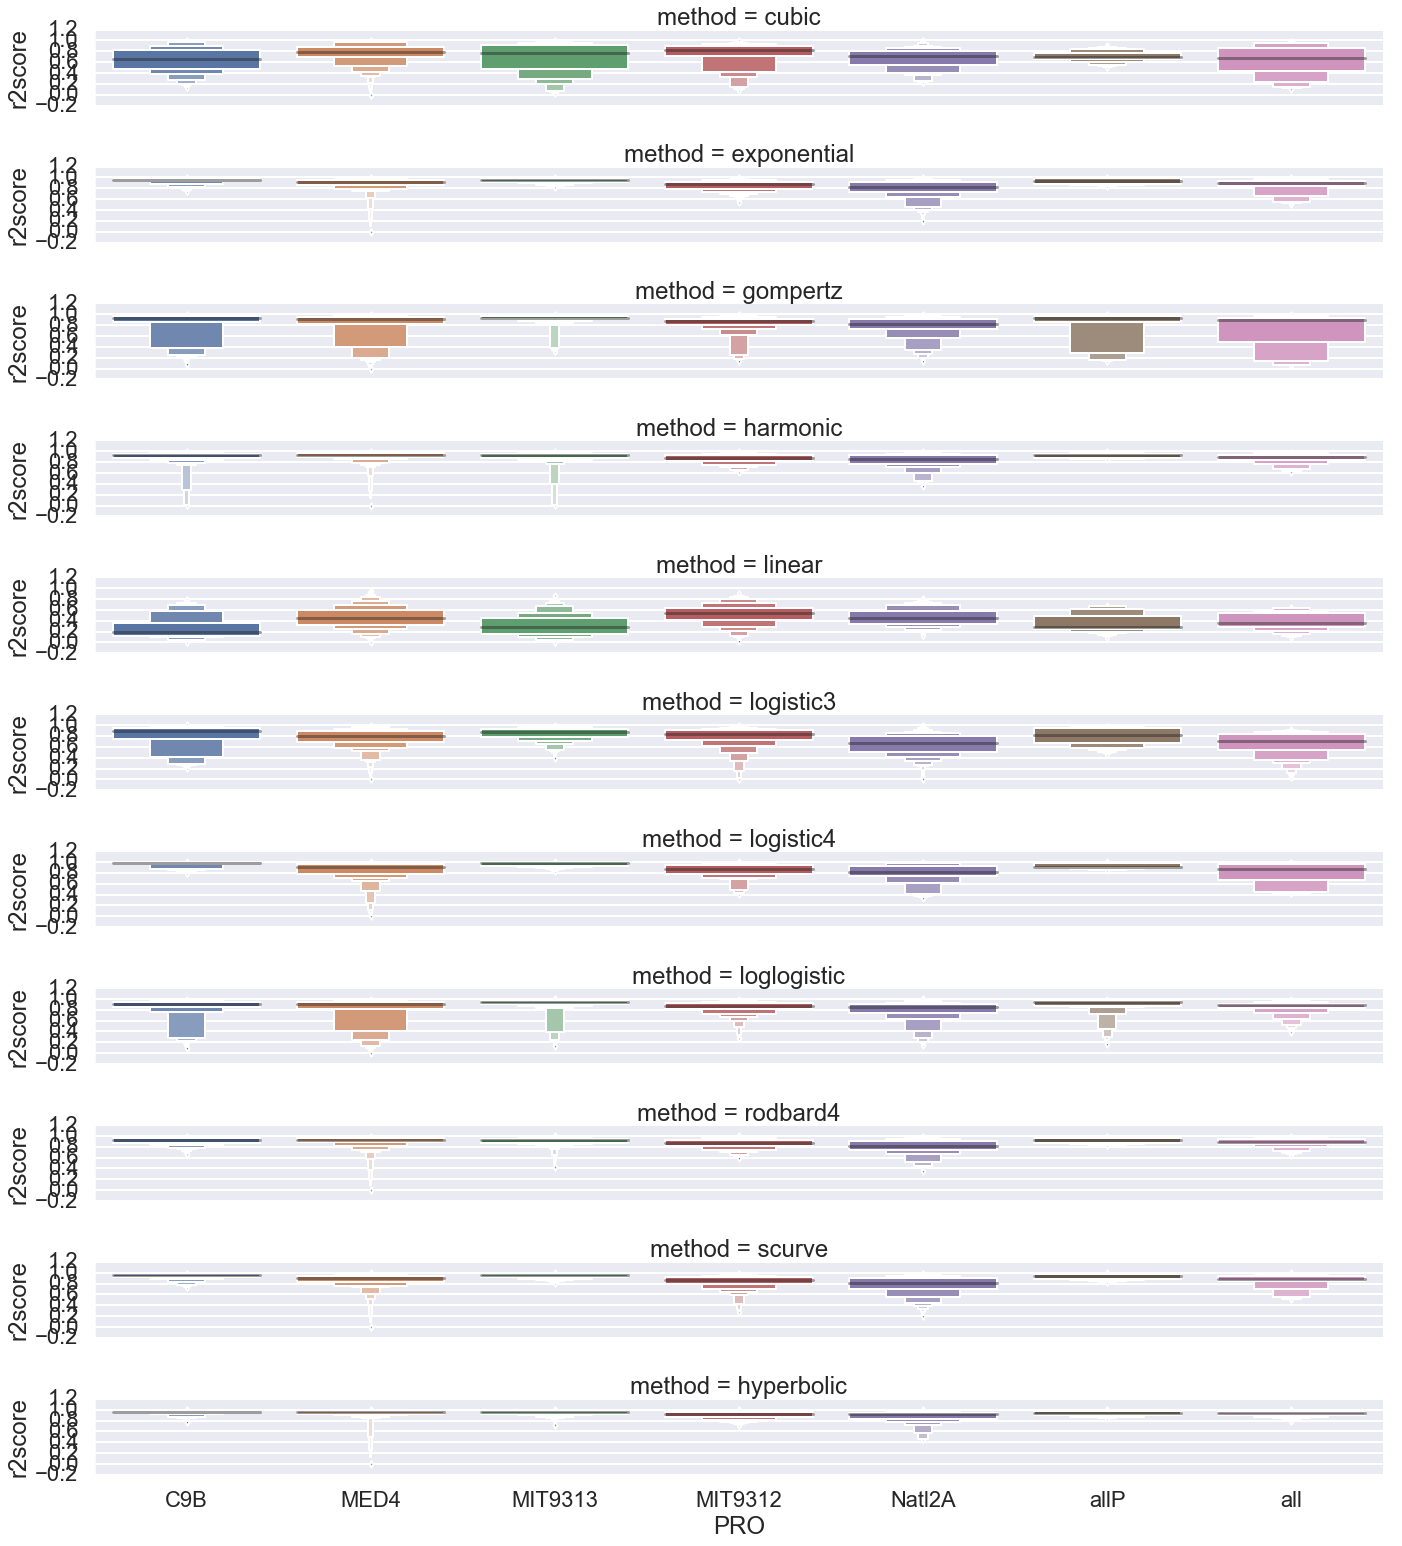

In [53]:
sns.catplot(data=scoresm, x='PRO', y='r2score', 
            #hue='PRO',
            kind='boxen', 
            row='method',
            aspect=10, height=2)

In [29]:
scores.max()

cubic            0.996624
exponential      0.993721
gompertz         0.990522
harmonic         0.992124
linear           0.954468
logistic3         0.99282
logistic4         0.99941
loglogistic      0.992668
rodbard4         0.992124
scurve           0.996031
hyperbolic       0.992794
PRO                  allP
ALT               all_Pro
sample                 9C
culture        Co_Culture
experiment             e7
dtype: object

In [30]:
scores.min()

cubic                0
exponential          0
gompertz             0
harmonic             0
linear               0
logistic3            0
logistic4            0
loglogistic          0
rodbard4             0
scurve               0
hyperbolic           0
PRO                C9B
ALT                1A3
sample             10A
culture        All_Pro
experiment          e1
dtype: object

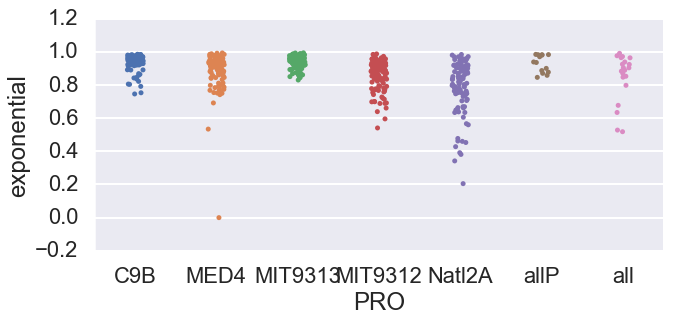

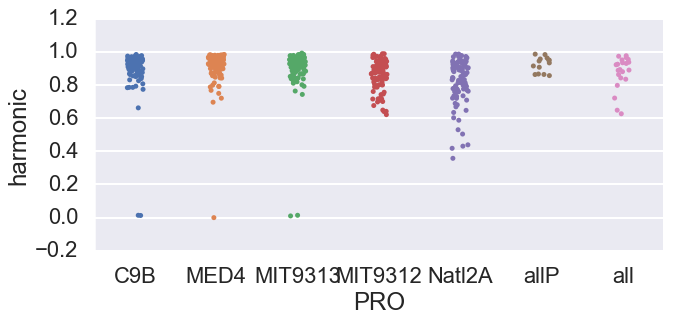

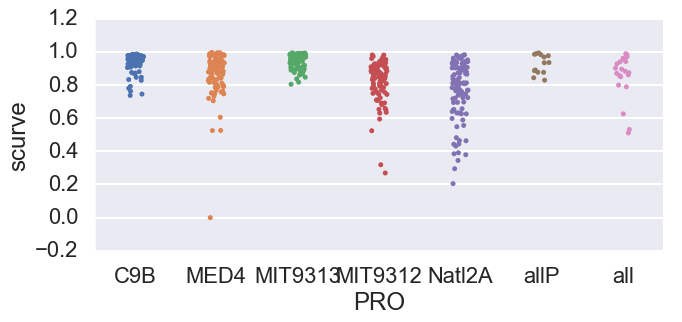

In [31]:
sns.catplot(data=scores, x='PRO', y='exponential', aspect=2)
sns.catplot(data=scores, x='PRO', y='harmonic', aspect=2)
sns.catplot(data=scores, x='PRO', y='scurve', aspect=2)

In [34]:
arr = np.argsort(-scores.loc[:,method_cols].values, axis=1)
best_model = pd.DataFrame(scores.columns[arr], index=scores.index)
for i in ['PRO','ALT', 'sample', 'culture', 'experiment']:
    best_model[i] = scores[i]
best_model

0            1            2            3  \
experiment_sample                                                       
e1, 10A             hyperbolic     rodbard4     harmonic  exponential   
e1, 10B             hyperbolic     harmonic     rodbard4     gompertz   
e1, 10C             hyperbolic     harmonic     rodbard4     gompertz   
e1, 11A             hyperbolic     rodbard4     harmonic  exponential   
e1, 11B             hyperbolic     rodbard4     harmonic     gompertz   
e1, 11C             hyperbolic     rodbard4     harmonic  loglogistic   
e1, 12A               gompertz   hyperbolic     rodbard4     harmonic   
e1, 12B              logistic4       scurve  exponential     gompertz   
e1, 12C              logistic4       scurve  exponential   hyperbolic   
e1, 13A             hyperbolic     harmonic  loglogistic     rodbard4   
e1, 13B               harmonic     rodbard4  loglogistic     gompertz   
e1, 13C               rodbard4     harmonic   hyperbolic  exponential   
e1, 14A             hyperbolic     harmonic     rodbard4  loglogistic   
e1, 14B               harmonic     rodbard4  loglogistic     gompertz   
e1, 14C               rodbard4     harmonic    logistic3   hyperbolic   
e1, 15A             hyperbolic     gompertz     harmonic     rodbard4   
e1, 15B             hyperbolic     gompertz  exponential       scurve   
e1, 15C            exponential       scurve   hyperbolic     harmonic   
e1, 16A             hyperbolic     harmonic     rodbard4     gompertz   
e1, 16B             hyperbolic     harmonic     rodbard4  exponential   
e1, 16C             hyperbolic     rodbard4     harmonic  loglogistic   
e1, 17A             hyperbolic     gompertz  loglogistic     harmonic   
e1, 17B             hyperbolic     harmonic  loglogistic  exponential   
e1, 17C             hyperbolic     gompertz  exponential     harmonic   
e1, 18A            loglogistic     rodbard4     harmonic     gompertz   
e1, 18B               harmonic     gompertz        cubic  exponential   
e1, 18C               rodbard4     harmonic     gompertz  loglogistic   
e1, 19A                 linear        cubic     harmonic     rodbard4   
e1, 19B            loglogistic       linear    logistic3     rodbard4   
e1, 19C            loglogistic     harmonic     rodbard4        cubic   
...                        ...          ...          ...          ...   
e7, 24C              logistic3        cubic     harmonic  loglogistic   
e7, 25C             hyperbolic     harmonic     rodbard4     gompertz   
e7, 2A               logistic4        cubic       scurve  exponential   
e7, 2C                  scurve    logistic4  exponential   hyperbolic   
e7, 36A             hyperbolic     rodbard4     harmonic     gompertz   
e7, 36B               harmonic   hyperbolic     rodbard4     gompertz   
e7, 37A              logistic4       scurve  exponential     harmonic   
e7, 37B              logistic4       scurve  exponential   hyperbolic   
e7, 37C              logistic4       scurve  exponential     gompertz   
e7, 3A                  scurve    logistic3  exponential     harmonic   
e7, 3B              hyperbolic  loglogistic     harmonic     rodbard4   
e7, 3C              hyperbolic     harmonic  loglogistic     rodbard4   
e7, 4A                harmonic  loglogistic    logistic3    logistic4   
e7, 4B                harmonic     rodbard4     gompertz  loglogistic   
e7, 4C                rodbard4     harmonic     gompertz  loglogistic   
e7, 5A                rodbard4        cubic     gompertz  loglogistic   
e7, 5B              hyperbolic     harmonic     rodbard4     gompertz   
e7, 5C              hyperbolic     rodbard4     harmonic     gompertz   
e7, 6A              hyperbolic     harmonic  loglogistic     gompertz   
e7, 6B                harmonic   hyperbolic     rodbard4  exponential   
e7, 6C                harmonic     rodbard4   hyperbolic       scurve   
e7, 7A                   cubic       scurve    logistic4   hyperbolic   
e7, 7B        

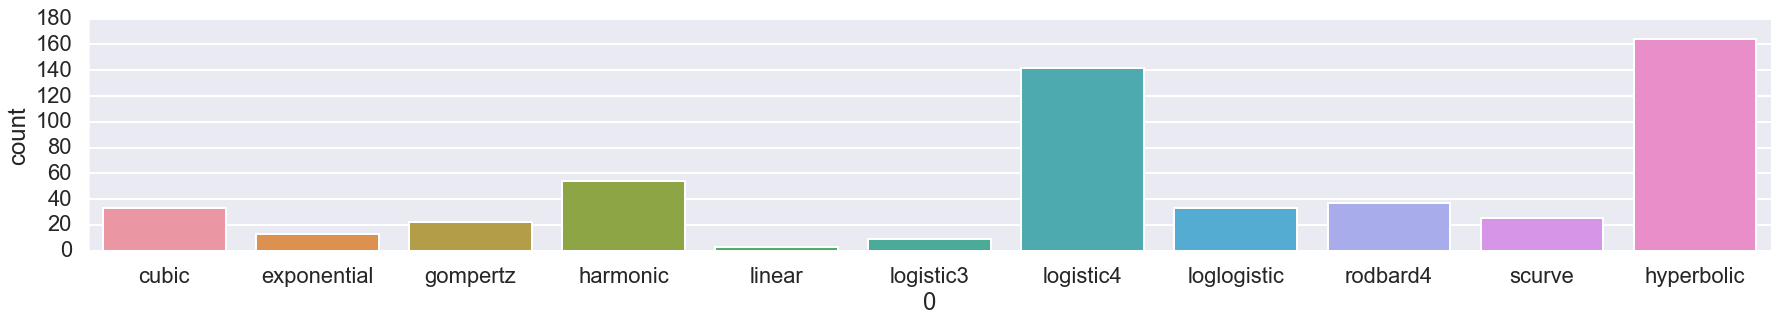

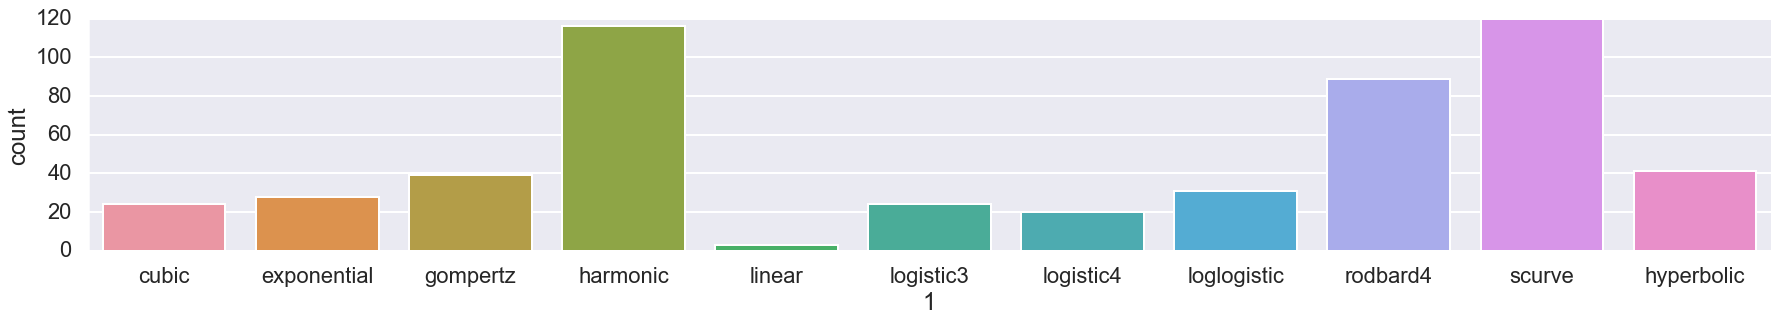

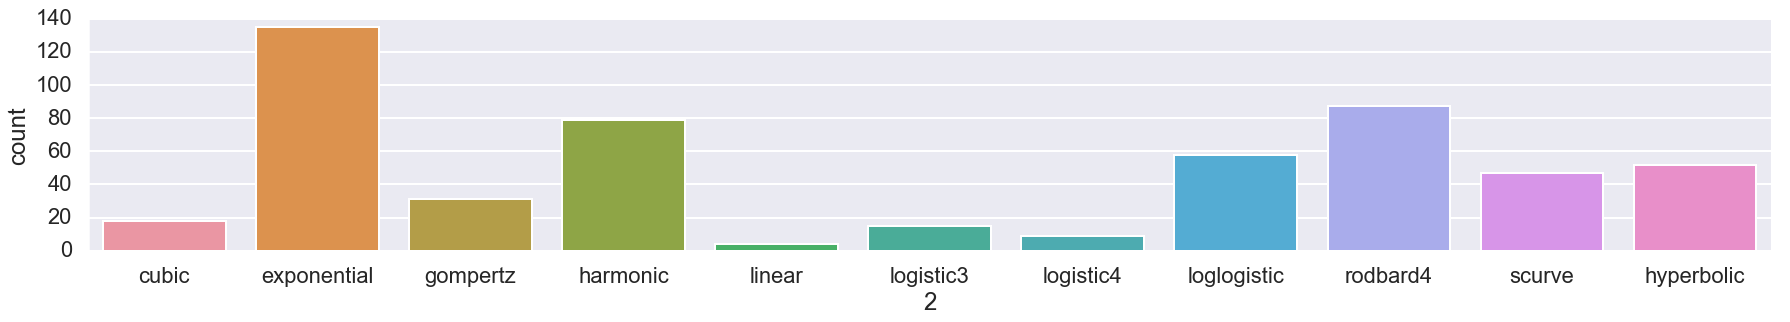

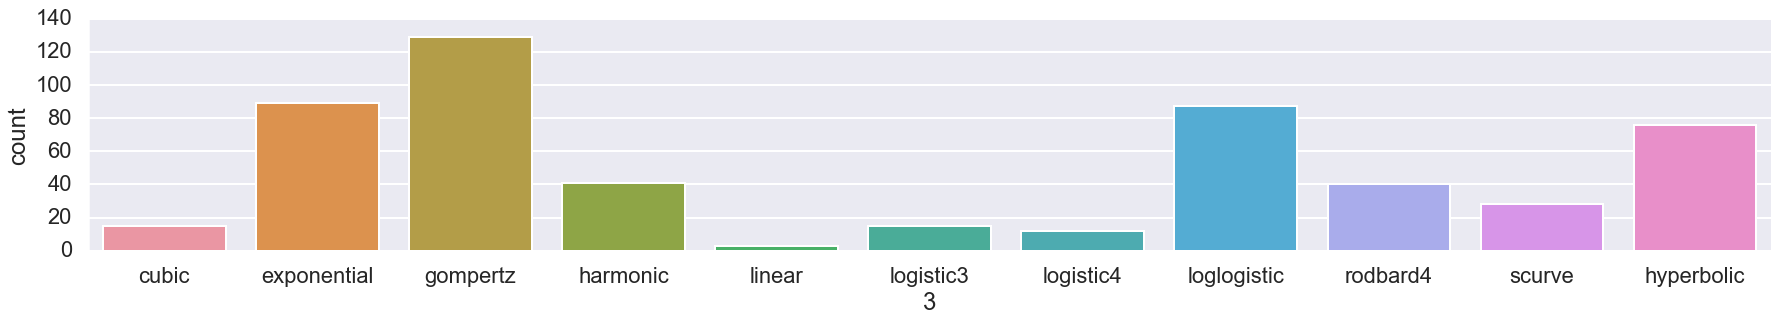

In [48]:


sns.catplot(data=best_model, #x='PRO',
            x=0, kind='count', aspect=5, 
            order=method_cols,
            #row='PRO', 
            #height=2
           )
sns.catplot(data=best_model, #x='PRO',
            x=1, kind='count', aspect=5, #row='PRO', 
            order=method_cols, #height=2
           )
sns.catplot(data=best_model, #x='PRO',
            x=2, kind='count', aspect=5, #row='PRO', 
            order=method_cols,
            #height=2
           )
sns.catplot(data=best_model, #x='PRO',
            x=3, kind='count', aspect=5, #row='PRO', 
            order=method_cols,
            #height=2
           )

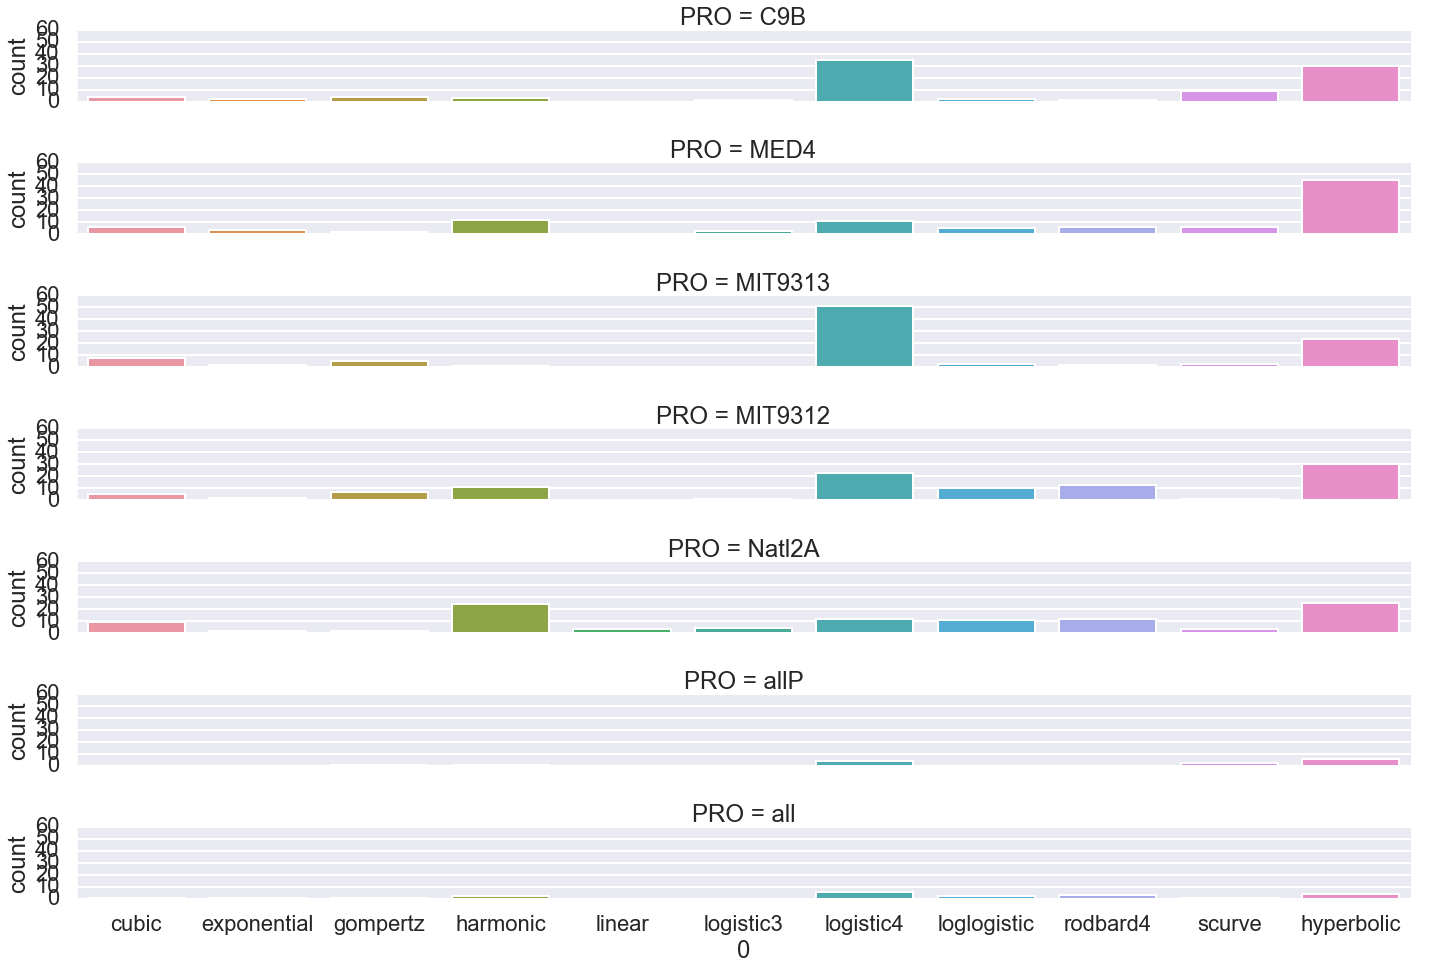

In [49]:
sns.catplot(data=best_model, #x='PRO',
            order=method_cols,
            x=0, kind='count', aspect=10, row='PRO', height=2)

In [40]:
scores.to_pickle('scores.pkl.gz')

In [41]:
dfe.to_pickle('dfe.pkl.gz')